In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from catboost import CatBoostClassifier, Pool

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 1. Функции

In [2]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Расчет метрики Hamming score, отражающей долю верно предсказанных
    элементов в объекте для задачи multi-label классификации
    '''
    acc_list = []
    
    # Цикл проходится по каждой паре таргет-предикт
    for i in range(y_true.shape[0]):
        # Для таргета и предикта создаются множества из индеков, на которых стоят единички
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])
        tmp_a = None
        
        # Если оба вектора состоят толька из ноликов, то предсказание абсолютно верно, и его скор = 1
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        
        # В противном случае количество верно предсказанных единичек делится на количество элементов
        # в объединенном множесте индексов единичек таргета и предикта. Таким образом, скор будет = 1
        # только в случае, если верно найдены все единички и нет ложных единичек
        else:
            tmp_a = len(set_true.intersection(set_pred)) / float(len(set_true.union(set_pred)))

        acc_list.append(tmp_a)
    return np.mean(acc_list)


def plot_matrix(y_true, y_pred, nrows, ncols):
    '''
    Отрисовка относительных матриц несоответствий для всех классов
    '''
    f, axes = plt.subplots(nrows, ncols, figsize=(25, 15))
    axes = axes.ravel()
    matrix = multilabel_confusion_matrix(y_true, y_pred)
    
    # Цикл проходится по всем классам
    for i in range(y_true.shape[1]):
        # В целевом классе (единички) определяется процентная доля верноположительных и ложноотрицательных
        # В нецелевом классе (нолики) определяется процентная доля верноотрицательных и ложноположительных
        percentages = matrix[i] / matrix[i].sum(axis=1).reshape(2, -1)
        
        disp = ConfusionMatrixDisplay(percentages, display_labels=[0, 1])
        disp.plot(ax=axes[i], cmap=plt.cm.Blues)
        disp.ax_.set_title(f'{y_test.columns[i]} ({str(y_test.iloc[:,i].sum())})')
        if i < (ncols * (nrows - 1)):
            disp.ax_.set_xlabel('')
        if i % ncols != 0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()


def evaluate(y_true, y_pred, save_file=False, filename='filename'):
    '''
    Выведение метрик для оценки качества работы модели.
    Опционально сохранение файла с предсказаниями модели
    '''
    print('Accuracy score:', round(accuracy_score(y_true, y_pred), 3))
    print('Hamming score:', round(hamming_score(y_true, y_pred), 3), '\n')
    print(classification_report(y_true, y_pred, target_names=y_test.columns, zero_division=0))
    if save_file:
        np.savetxt(filename, y_pred.astype(int), fmt='%i', delimiter=',')

# 2. Датасет

In [3]:
df_train = pd.read_csv('kinopoisk_train.csv')
df_test = pd.read_csv('kinopoisk_test.csv')

X_train, y_train = df_train['descr_lemmas'], df_train.drop('descr_lemmas', axis=1)
X_test, y_test = df_test['descr_lemmas'], df_test.drop('descr_lemmas', axis=1)

# 3. Модель на униграммах

In [4]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 1)
    )),
    ('catboost', MultiOutputClassifier(
        estimator=CatBoostClassifier(
            task_type='CPU',
            iterations=100,
            verbose=True,
            random_state=42,
        ))),
])

pipe.fit(
    X_train,
    y_train,
    catboost__verbose=50
)

Learning rate set to 0.5
0:	learn: 0.2156347	total: 676ms	remaining: 1m 6s
50:	learn: 0.0803924	total: 34.1s	remaining: 32.8s
99:	learn: 0.0677148	total: 1m 11s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2315124	total: 681ms	remaining: 1m 7s
50:	learn: 0.1059408	total: 43.1s	remaining: 41.5s
99:	learn: 0.0953328	total: 1m 27s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4499660	total: 599ms	remaining: 59.3s
50:	learn: 0.2675124	total: 37.7s	remaining: 36.2s
99:	learn: 0.2460527	total: 1m 5s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1423576	total: 513ms	remaining: 50.8s
50:	learn: 0.0273042	total: 48s	remaining: 46.1s
99:	learn: 0.0219680	total: 1m 30s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2417826	total: 517ms	remaining: 51.2s
50:	learn: 0.0746980	total: 47.7s	remaining: 45.9s
99:	learn: 0.0636949	total: 1m 31s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3616871	total: 619ms	remaining: 1m 1s
50:	learn: 0.2149933	total: 42.6s	remaining: 40.

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('catboost',
                 MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x0000027EFFB15590>))])

### Оценка

In [5]:
y_pred = pipe.predict(X_test)
evaluate(y_test.to_numpy(), y_pred, save_file=True, filename='tfidf_catboost_ngram_1_1.csv')
joblib.dump(pipe, 'model_tfidf_catboost_ngram_1_1.pkl')

Accuracy score: 0.13
Hamming score: 0.326 

                 precision    recall  f1-score   support

          аниме       0.73      0.24      0.36       659
      биография       0.56      0.12      0.19       753
         боевик       0.68      0.32      0.44      2813
        вестерн       0.84      0.39      0.53       303
        военный       0.65      0.40      0.49       818
       детектив       0.60      0.26      0.36      1923
        детский       0.59      0.18      0.27       380
   для взрослых       0.75      0.04      0.08        72
 документальный       0.80      0.36      0.50      1267
          драма       0.66      0.57      0.62      9840
        история       0.50      0.15      0.23       941
        комедия       0.69      0.29      0.41      6042
короткометражка       0.74      0.20      0.31      1951
       криминал       0.63      0.36      0.46      2660
      мелодрама       0.64      0.32      0.42      4191
         музыка       0.55      0.23      0

['model_tfidf_catboost_ngram_1_1.pkl']

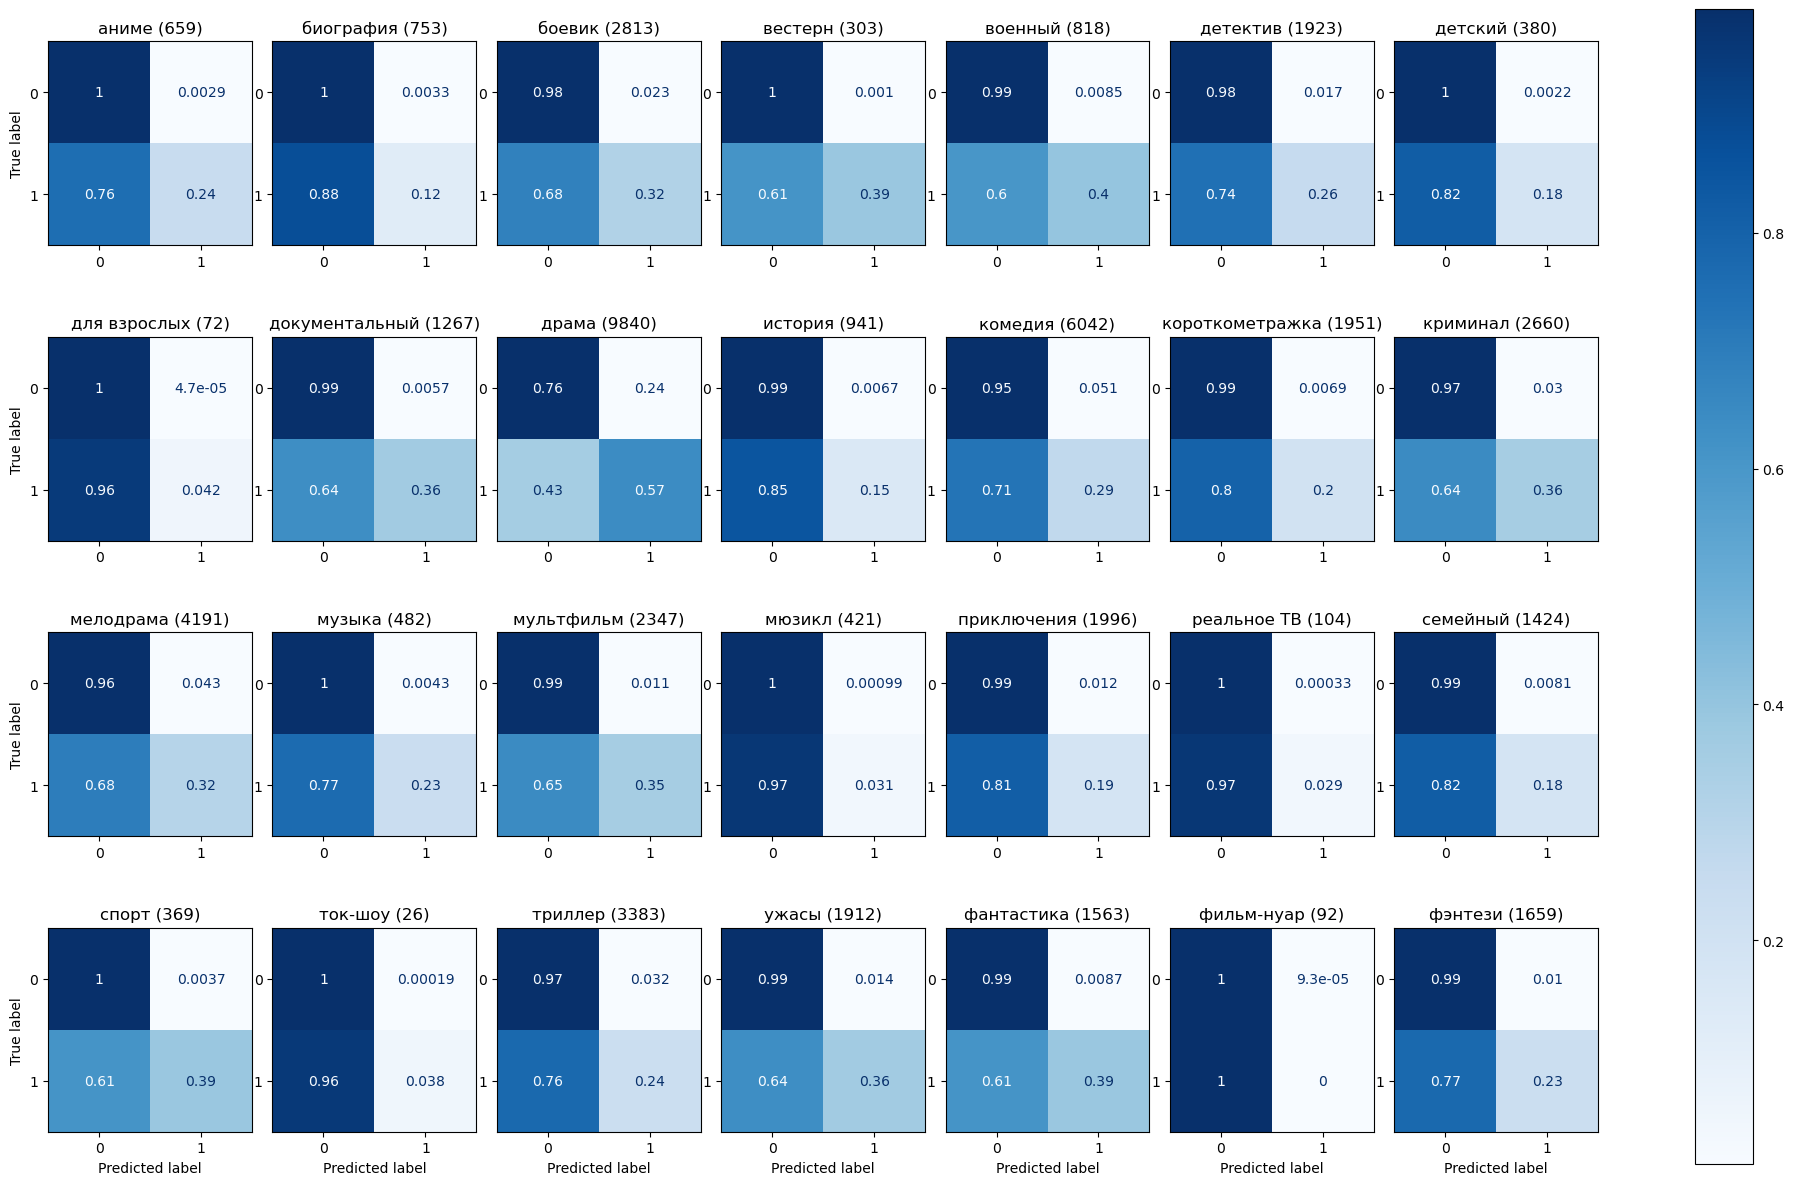

In [6]:
plot_matrix(y_test, y_pred, nrows=4, ncols=7)

# 4. Модель на униграммах + биграммах

In [7]:
%%time
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1, 2)
    )),
    ('catboost', MultiOutputClassifier(
        estimator=CatBoostClassifier(
            task_type='CPU',
            iterations=100,
            verbose=True,
            random_state=42,
        ))),
])

pipe.fit(
    X_train,
    y_train,
    catboost__verbose=50
)

Learning rate set to 0.5
0:	learn: 0.2157647	total: 5s	remaining: 8m 14s
50:	learn: 0.0797651	total: 4m 33s	remaining: 4m 22s
99:	learn: 0.0667412	total: 8m 45s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2316083	total: 5.75s	remaining: 9m 29s
50:	learn: 0.1055259	total: 5m	remaining: 4m 49s
99:	learn: 0.0931526	total: 9m 46s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4466745	total: 5.99s	remaining: 9m 53s
50:	learn: 0.2665467	total: 5m 1s	remaining: 4m 49s
99:	learn: 0.2454220	total: 9m 53s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1423968	total: 6.15s	remaining: 10m 9s
50:	learn: 0.0270799	total: 5m 22s	remaining: 5m 10s
99:	learn: 0.0203342	total: 10m 30s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2064756	total: 5.88s	remaining: 9m 42s
50:	learn: 0.0745589	total: 5m 28s	remaining: 5m 15s
99:	learn: 0.0632752	total: 10m 37s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3597826	total: 7.05s	remaining: 11m 37s
50:	learn: 0.2141840	total: 5m 30s

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('catboost',
                 MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x0000027E8E286250>))])

### Оценка

In [8]:
y_pred = pipe.predict(X_test)
evaluate(y_test.to_numpy(), y_pred, save_file=True, filename='tfidf_catboost_ngram_1_2.csv')
joblib.dump(pipe, 'model_tfidf_catboost_ngram_1_2.pkl')

Accuracy score: 0.13
Hamming score: 0.353 

                 precision    recall  f1-score   support

          аниме       0.69      0.22      0.33       659
      биография       0.51      0.15      0.23       753
         боевик       0.62      0.38      0.47      2813
        вестерн       0.79      0.45      0.57       303
        военный       0.60      0.46      0.52       818
       детектив       0.57      0.30      0.40      1923
        детский       0.58      0.21      0.31       380
   для взрослых       0.29      0.03      0.05        72
 документальный       0.75      0.42      0.54      1267
          драма       0.65      0.61      0.63      9840
        история       0.48      0.21      0.29       941
        комедия       0.66      0.33      0.44      6042
короткометражка       0.59      0.26      0.36      1951
       криминал       0.60      0.43      0.50      2660
      мелодрама       0.62      0.38      0.47      4191
         музыка       0.50      0.27      0

['model_tfidf_catboost_ngram_1_2.pkl']

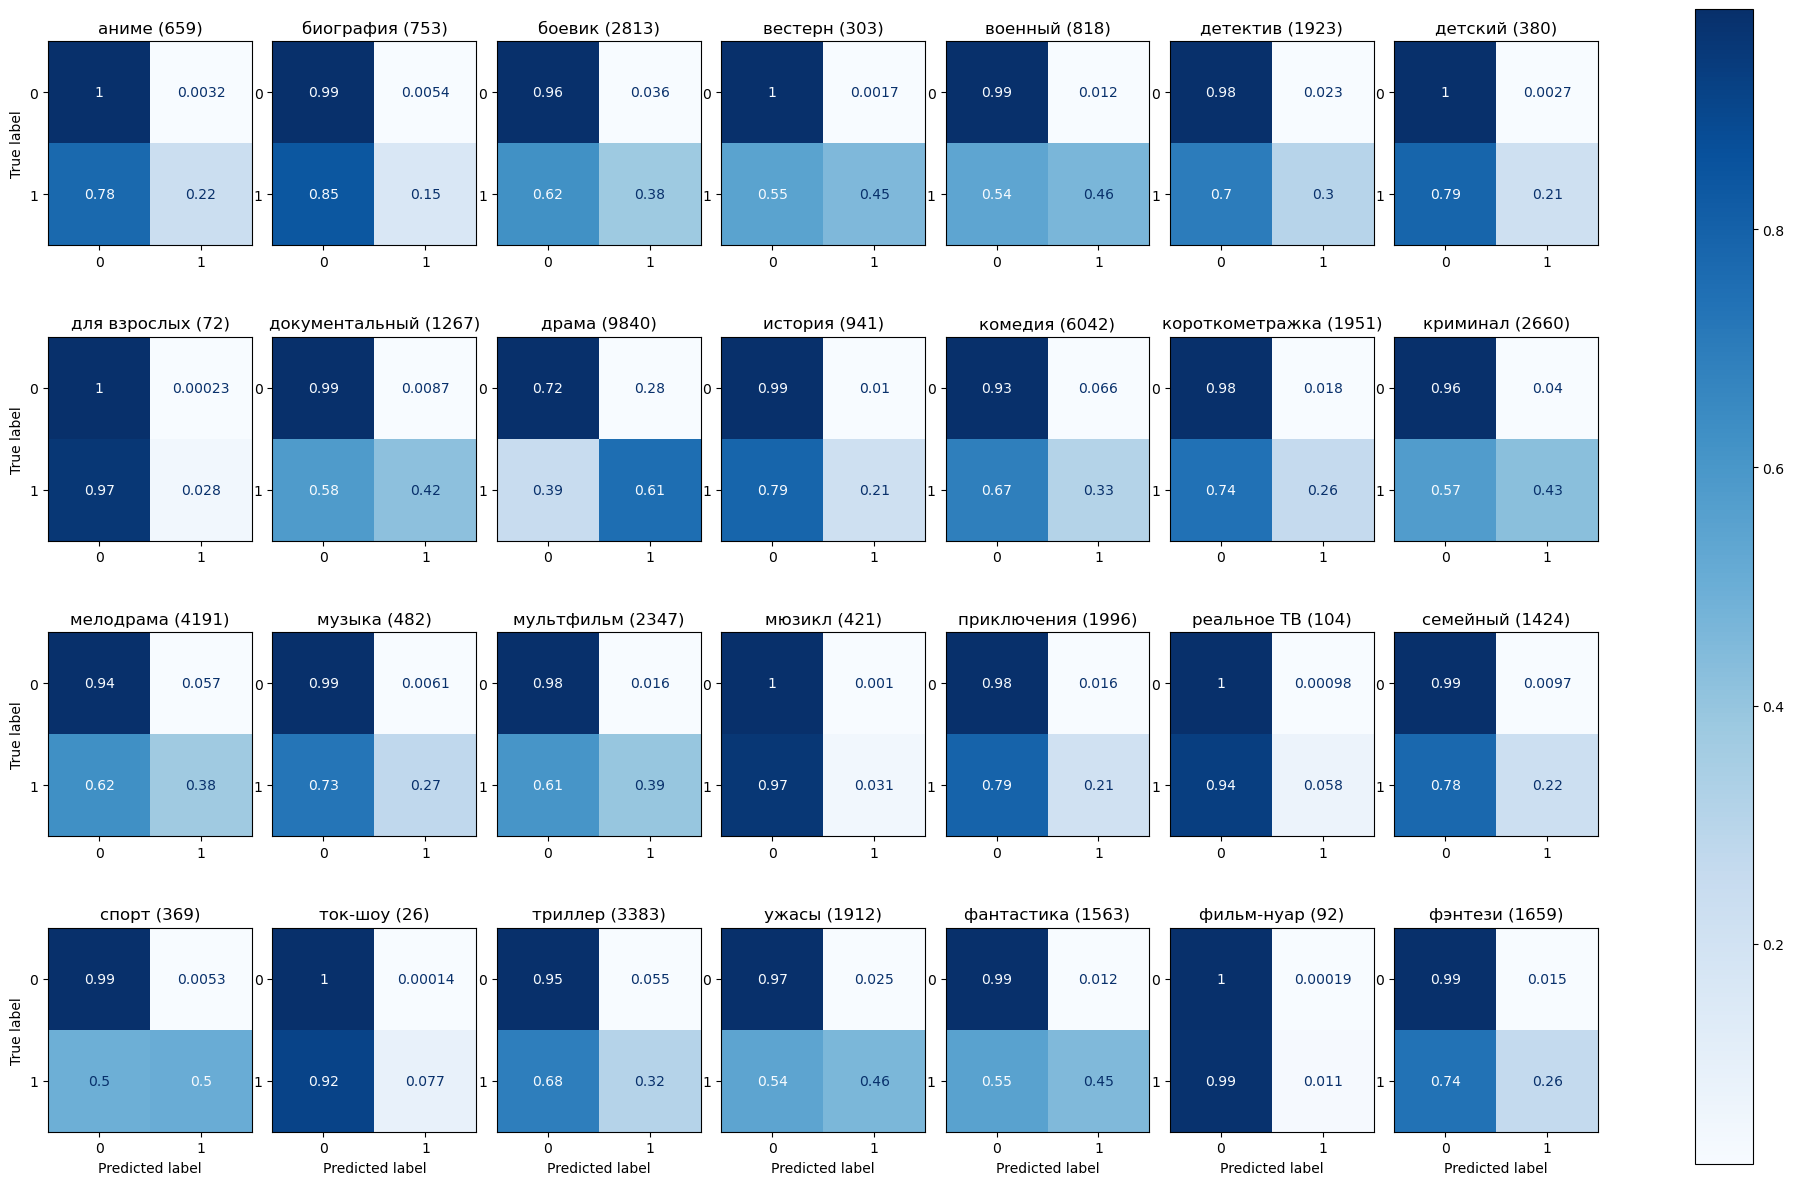

In [9]:
plot_matrix(y_test, y_pred, nrows=4, ncols=7)